In [3]:
%cd Neurex\ Winter\ Break\ Data


[Errno 2] No such file or directory: 'Neurex Winter Break Data'
/Users/efang/Desktop/coding/HAR/Neurex Winter Break Data


## Library Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

## Data Importing

In [5]:
train_prefix, test_prefix = 'train/Inertial Signals/', 'test/Inertial Signals/'
train_suffix, test_suffix = '_train.txt', '_test.txt'
axes = ['total_acc_x', 'total_acc_y', 'total_acc_z', 'body_gyro_x', 'body_gyro_y', 'body_gyro_z']
activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
window_size = 128

def load_and_reshape_data(filepath):
    '''
    Takes in an input file with space/tab/newline seperated values
    and places the data into a matrix with 128 columns
    '''
    with open(filepath, 'r') as file:
        rawdata = np.array(file.read().split(), dtype=float)

    if len(rawdata) % window_size != 0:
        raise ValueError(f"Number of readings ({len(rawdata)}) is not divisible by 128 for filepath {filepath}.")

    return rawdata.reshape(-1, window_size)


def combine_axes(features, prefix, suffix):
  '''
  Helper function that loads in data from all 6 axes and combines them together into one matrix
  '''
  builder = []

  for axis in features:
    filepath = prefix + axis + suffix
    axis_matrix = load_and_reshape_data(filepath)
    builder.append(axis_matrix)

  return np.stack(builder, axis=2)


# create train/test input/output sets
train_input = combine_axes(axes, train_prefix, train_suffix)
with open('train/y' + train_suffix) as file:
  train_output = np.array(file.read().split(), dtype=int) - 1

test_input = combine_axes(axes, test_prefix, test_suffix)
with open('test/y' + test_suffix) as file:
  test_output = np.array(file.read().split(), dtype=int) - 1

# create subject identification lists
with open('train/subject' + train_suffix) as file:
  train_subject_ids = np.array(file.read().split(), dtype=int)

with open('test/subject' + test_suffix) as file:
  test_subject_ids = np.array(file.read().split(), dtype=int)

# verify shapes of data created
print(f"Train input: {train_input.shape}")
print(f"Train output: {train_output.shape}")
print(f"Test input: {test_input.shape}")
print(f"Test output: {test_output.shape}")
print(f"Train Subject IDs: {train_subject_ids.shape}")
print(f"Test Subject IDs: {test_subject_ids.shape}")

Train input: (7352, 128, 6)
Train output: (7352,)
Test input: (2947, 128, 6)
Test output: (2947,)
Train Subject IDs: (7352,)
Test Subject IDs: (2947,)


## Testing Overlap Percentage

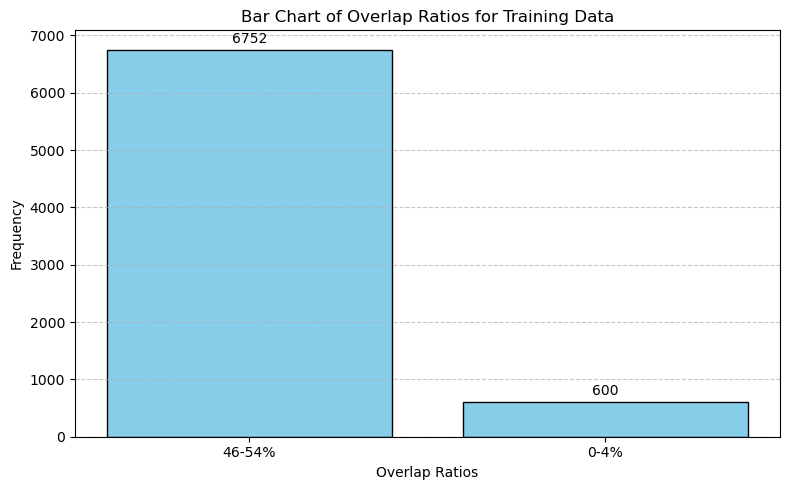

In [6]:
def calculate_overlap(arr1, arr2):
    '''
    Given two 1D arrays of the same size, this function calculates the number of unique elements
    in both arrays and returns the ratio of these elements to the size of the original array.

    This function is used to calculate the overlap percentage between two windows
    '''
    if arr1.shape != arr2.shape:
        raise ValueError("Arrays must have the same shape to calculate overlap.")

    common_elements = np.intersect1d(arr1, arr2)
    return len(common_elements) / len(arr2)


def calculate_overlap_locations(axis):
  '''
  Theoretically, the overlap ratios for given dataset should be either 50% or 0% (50% getting the highest frequency)
  In order to observe

    1. Where in the list zero overlap rates occur
    2. Where in the list unexpected overlap rates occur

  This functions calculates the overlap ratios for all adjacent sample pairs and takes note of where
  0% and other overlap rates occur.
  '''
  ratios = defaultdict(int)
  zero_locations = []
  other_locations = []

  for pair in range(len(train_input)-1):
    overlap_ratio = round(calculate_overlap(train_input[pair, :, axis], train_input[pair+1, :, axis]), 5)
    if 0 <= overlap_ratio < 0.04:
      ratios['0-4%'] += 1
      zero_locations.append(pair)
    elif 0.46 < overlap_ratio < 0.54:
      ratios['46-54%'] += 1
    else:
      ratios['Other'] += 1
      other_locations.append(pair)

  # since the last sample has no successor to overlap with
  zero_locations.append(len(train_input)-1)
  ratios['0-4%'] += 1

  # for printing the bar chart of overlapping ratios (which should be the same for all axes, hence only printing once)
  if axis == 0:
    categories = list(ratios.keys())
    values = list(ratios.values())
    plt.figure(figsize=(8, 5))
    plt.bar(categories, values, color='skyblue', edgecolor='black')
    plt.xlabel('Overlap Ratios')
    plt.ylabel('Frequency')
    plt.title('Bar Chart of Overlap Ratios for Training Data')

    for i, value in enumerate(values):
        plt.text(i, value + max(values) * 0.01, str(value), ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

  return (zero_locations, other_locations)

# check to make sure that the locations where zero/other overlap ratios occur
# are the same for all axes
zero_locations, other_locations = calculate_overlap_locations(0)
for axis in range(1, len(axes)):
  zi, oi = calculate_overlap_locations(axis)
  if zi != zero_locations or oi != other_locations:
    print(f"Axis {axis} doesn't have matching overlap rates as acc_x")

#### Comparing Activity Chunks and Zero Overlap Rate

In [7]:
activity_chunks = []  # array of chunk intervals
start = 0    # beginning of each chunk interval
current_activity = train_output[0]

for sample in range(1, len(train_output)-1):
  # when the activity label changes
  if train_output[sample] != current_activity:
    activity_chunks.append((start, sample-1)) # add previous chunk

    start = sample   # initalize info for new chunk
    current_activity = train_output[sample]

# handle the final element
if train_output[-1] == current_activity:
  activity_chunks.append((start, len(train_output)-1))
else:
  activity_chunks.append((start, len(train_output)-2))
  activity_chunks.append((len(train_output)-1, len(train_output)-1))


# figure out what ratio of zero locations are due to explicit activity changes
zeros_due_to_activity_change = []
search = 0   # ptr that goes through the chunks array

for index in zero_locations:
  # since chunks and zero_locations are in sorted order, we can perform search efficiently
  while search < len(activity_chunks) and index > activity_chunks[search][1]:
    search += 1

  if index == activity_chunks[search][1]:
    zeros_due_to_activity_change.append(index)
print(f"Ratio of Zero Overlapping Rates Due to Activity Change: {len(zeros_due_to_activity_change) / len(zero_locations)}")


# figure out if all activity chunks are independent of each other
activity_chunks_with_zero_overlap = []
search = 0   # ptr that goes through zero_locations array

for index, (start, end) in enumerate(activity_chunks):
  # since chunks and zero_locations are in sorted order, we can perform search efficiently
  while search < len(zero_locations)-1 and end > zero_locations[search]:
    search += 1

  if end == zero_locations[search]:
    activity_chunks_with_zero_overlap.append((start, end))
print(f"Ratio of Activities with Zero Overlapping Rate: {len(activity_chunks_with_zero_overlap) / (len(activity_chunks))}\n")

Ratio of Zero Overlapping Rates Due to Activity Change: 0.4666666666666667
Ratio of Activities with Zero Overlapping Rate: 1.0



## Transform Data into Non-Overlapping Windows

In [8]:
new_window_size = window_size // 2
transformed_train_input = np.empty((0, new_window_size, 6))
transformed_train_output = []
transformed_train_subjects = []
zero_index = 0

for sample in range(len(train_input)):
  activity_label = train_output[sample]
  subject_id = train_subject_ids[sample]

  # if no overlap with successor, load both halves into the new train input
  if zero_index < len(zero_locations) and sample == zero_locations[zero_index]:
    transformed_train_input = np.concatenate((transformed_train_input, train_input[sample:sample+1, :new_window_size, :]), axis=0)
    transformed_train_input = np.concatenate((transformed_train_input, train_input[sample:sample+1, new_window_size:, :]), axis=0)

    # since two samples are being added, this will happen twice
    transformed_train_output.append(activity_label)
    transformed_train_subjects.append(subject_id)
    zero_index += 1

  # if 50% overlap with successor, load in only the first half
  else:
    transformed_train_input = np.concatenate((transformed_train_input, train_input[sample:sample+1, :new_window_size, :]), axis=0)

  transformed_train_output.append(activity_label)
  transformed_train_subjects.append(subject_id)

train_input = transformed_train_input
train_output = np.array(transformed_train_output)
train_subject_ids = np.array(transformed_train_subjects)

print(train_input.shape)
print(train_output.shape)
print(train_subject_ids.shape)

(7952, 64, 6)
(7952,)
(7952,)


## Create Subject Chunks

In [9]:
subject_chunks = []  # array of chunk intervals
start = 0    # beginning of each chunk interval
current_subject = train_subject_ids[0]

for sample in range(1, len(train_subject_ids)-1):
  # when the activity label changes
  if train_subject_ids[sample] != current_subject:
    subject_chunks.append((start, sample-1)) # add previous chunk

    start = sample   # initalize info for new chunk
    current_subject = train_subject_ids[sample]

# handle the final element
if train_subject_ids[-1] == current_subject:
  subject_chunks.append((start, len(train_subject_ids)-1))
else:
  subject_chunks.append((start, len(train_subject_ids)-2))
  subject_chunks.append((len(train_subject_ids)-1, len(train_subject_ids)-1))

print(subject_chunks)

[(0, 379), (380, 749), (750, 1079), (1080, 1432), (1433, 1768), (1769, 2078), (2079, 2423), (2424, 2774), (2775, 3130), (3131, 3524), (3525, 3921), (3922, 4309), (4310, 4745), (4746, 5094), (5095, 5494), (5495, 5931), (5932, 6351), (6352, 6756), (6757, 7167), (7168, 7540), (7541, 7951)]


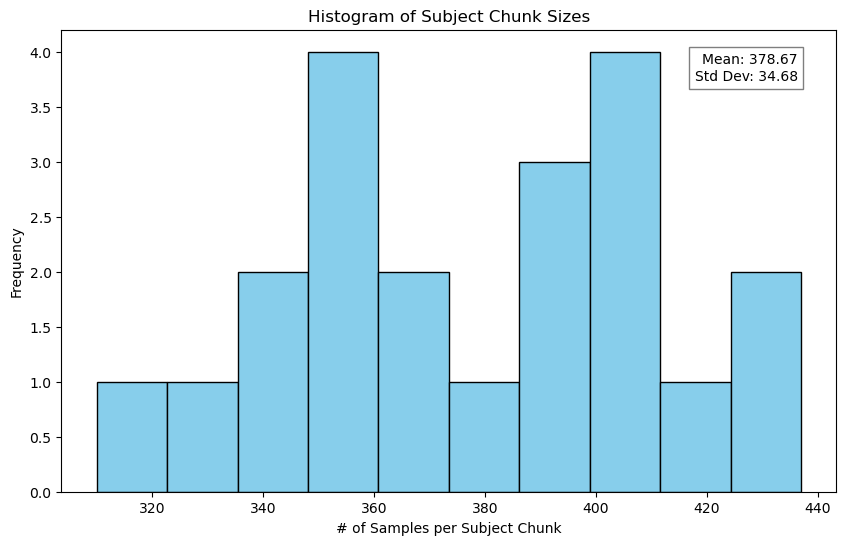

In [10]:
num_subjects = len(np.unique(train_subject_ids))
subject_sizes = []
for start, end in subject_chunks:
  subject_sizes.append(end-start+1)

plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(subject_sizes, color='skyblue', edgecolor='black')
plt.title('Histogram of Subject Chunk Sizes')
plt.xlabel('# of Samples per Subject Chunk')
plt.ylabel('Frequency')

stats_text = f"Mean: {np.mean(subject_sizes):.2f}\nStd Dev: {np.std(subject_sizes):.2f}"
plt.text(
    0.95, 0.95, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black')
)
plt.show()

## Create a K-Fold Cross Validation Function

In [11]:
def cross_val_score(estimator, X, y, scoring, cv=5):
  '''
  Given an estimator model, input, expected output, a scoring function, and the number of folds
  this function will perform kfold cross validation. It create folds by randomly assigning 4 subject chunks
  (without replacement) into each fold.
  '''

  # ensure dimensions of input match
  if X.shape[0] != y.shape[0]:
    raise ValueError(f"Shape of input 'X' {X.shape} and output 'y' {y.shape} don't match")
  y = y.reshape(-1, 1) if y.ndim == 1 else y
  combined = np.hstack((X, y))

  # fill in folds randomly
  folds = [np.empty((0, combined.shape[1])) for _ in range(cv)]
  available_subjects = set(np.arange(num_subjects))

  subjects_per_fold = len(available_subjects) // cv
  for f in range(len(folds)):
    for i in range(subjects_per_fold):
      # pick a random fold
      subject = random.sample(available_subjects, 1)[0]
      available_subjects.remove(subject)
      start, end = subject_chunks[subject]
      folds[f] = np.concatenate((folds[f], combined[start:(end+1), :]), axis=0)

  # assign the single remaining subject (since 4*5 = 20 < 21) to the last fold
  subject = random.sample(available_subjects, 1)[0]
  start, end = subject_chunks[subject]
  folds[-1] = np.concatenate((folds[-1], combined[start:(end+1), :]), axis=0)


  scores = []
  for val_fold in range(len(folds)):
    # treat current fold as the validation set
    validation_input = folds[val_fold][:, :-1]
    validation_output = folds[val_fold][:, -1]

    # combined all other folds into train set
    train_input = np.empty((0, combined.shape[1]))
    train_output = np.zeros(0, dtype=int)

    for train_fold in range(len(folds)):
      if train_fold != val_fold:
        train_input = np.concatenate((train_input, folds[val_fold][:, :-1]), axis=0)
        train_ouput = np.concatenate((train_output, folds[val_fold][:, -1]))

    estimator = estimator.fit(train_input, train_output)
    predictions = estimator.predict(validation_input)
    # POSSIBLY ADD SOME OUTPUT SMOOTHING HERE IF NEEDED
    scores.append(scoring(validation_output, predictions))

# Model Architecture


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [18]:
train_input, val_input, train_output, val_output = train_test_split(
    train_input,
    train_output,
    test_size=0.2,
    random_state=42,
    shuffle=False
)

In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_size=128, num_classes=6, dropout=0.5):
        """
          - 3 stacked LSTM layers, each with hidden_size=128 (basically output of 1 layer -> input to next layer... that's all the hidden state is)
          - 50% dropout after each LSTM layer (avoid overfitting)
          - fully connected layer for classification
        """
        super(LSTM, self).__init__()

        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.dropout1 = nn.Dropout(p=dropout)

        self.lstm2 = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.dropout2 = nn.Dropout(p=dropout)

        self.lstm3 = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.dropout3 = nn.Dropout(p=dropout)

        # classification layer

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """
        out1, (h1, c1) = self.lstm1(x)
        out1 = self.dropout1(out1)


        out2, (h2, c2) = self.lstm2(out1)
        out2 = self.dropout2(out2)


        out3, (h3, c3) = self.lstm3(out2)
        out3 = self.dropout3(out3)

        out = out3[:, -1, :]


        logits = self.fc(out)
        return logits


# Training

In [15]:
def evaluate(model, inputs, targets, criterion, device):
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        loss = criterion(outputs, targets)
    _, predicted = torch.max(outputs, 1)
    predicted_np = predicted.detach().cpu().numpy()
    targets_np = targets.detach().cpu().numpy()

    micro_f1 = f1_score(targets_np, predicted_np, average='micro')
    macro_f1 = f1_score(targets_np, predicted_np, average='macro')
    cm = confusion_matrix(targets_np, predicted_np)

    return loss.item(), micro_f1, macro_f1, cm

def plot_confusion_matrix(cm, class_names):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(18, 18))
    disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        avg_train_loss = train_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val)
                loss = criterion(val_outputs, y_val)
                val_loss += loss.item() * X_val.size(0)
        avg_val_loss = val_loss / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = torch.save(model.state_dict(), "best_model.pt")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    # Restore best model
    model.load_state_dict(torch.load("best_model.pt"))
    return model


In [22]:
def main(train_input, train_output, test_input, test_output):

    input_size = 6
    hidden_size = 128
    dropout = 0.5
    learning_rate = 1e-3
    epochs = 300
    batch_size = 128
    patience = 30

    from sklearn.model_selection import train_test_split

    train_input, val_input, train_output, val_output = train_test_split(
        train_input, train_output, test_size=0.2, shuffle=False, random_state=42
    )


    train_input_tensor = torch.from_numpy(train_input).float()
    train_output_tensor = torch.from_numpy(train_output).long()

    val_input_tensor = torch.from_numpy(val_input).float()
    val_output_tensor = torch.from_numpy(val_output).long()

    # dataloader
    train_dataset = TensorDataset(train_input_tensor, train_output_tensor)
    val_dataset = TensorDataset(val_input_tensor, val_output_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # model, optimizer
    model = LSTM(input_size=input_size, hidden_size=hidden_size, num_classes=6, dropout=dropout)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion.to(device)

    # train
    model = train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience)

    # evaluation
    test_input_tensor = torch.from_numpy(test_input).float().to(device)
    test_output_tensor = torch.from_numpy(test_output).long().to(device)

    final_test_loss, micro_f1, macro_f1, cm = evaluate(model, test_input_tensor, test_output_tensor, criterion, device)
    print(f"Final Loss (test): {final_test_loss:.4f}, Micro-F1: {micro_f1:.4f}, Macro-F1: {macro_f1:.4f}")

    # confusion matrix
    plot_confusion_matrix(cm, ['Walking', 'Walking Upstairs', 'Walking Downstairs', 'Sitting', 'Standing', 'Laying'])


Epoch 1/300, Train Loss: 1.6386, Val Loss: 1.3672
Epoch 2/300, Train Loss: 1.3747, Val Loss: 1.3337
Epoch 3/300, Train Loss: 1.3585, Val Loss: 1.3202
Epoch 4/300, Train Loss: 1.3505, Val Loss: 1.2956
Epoch 5/300, Train Loss: 1.3219, Val Loss: 1.2322
Epoch 6/300, Train Loss: 1.3201, Val Loss: 1.3047
Epoch 7/300, Train Loss: 1.2502, Val Loss: 1.1544
Epoch 8/300, Train Loss: 1.1798, Val Loss: 1.1832
Epoch 9/300, Train Loss: 1.2056, Val Loss: 1.1583
Epoch 10/300, Train Loss: 1.1827, Val Loss: 1.0975
Epoch 11/300, Train Loss: 1.0758, Val Loss: 0.9292
Epoch 12/300, Train Loss: 0.9117, Val Loss: 0.7732
Epoch 13/300, Train Loss: 1.0710, Val Loss: 1.3566
Epoch 14/300, Train Loss: 1.2803, Val Loss: 1.1701
Epoch 15/300, Train Loss: 1.0847, Val Loss: 0.7518
Epoch 16/300, Train Loss: 0.8574, Val Loss: 0.7194
Epoch 17/300, Train Loss: 0.8118, Val Loss: 0.7419
Epoch 18/300, Train Loss: 0.8357, Val Loss: 0.7012
Epoch 19/300, Train Loss: 0.8418, Val Loss: 0.7226
Epoch 20/300, Train Loss: 0.7999, Val Lo

/var/folders/nv/rghb2gs96kv8xxl7t7h21vp00000gn/T/ipykernel_66951/3247603485.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model

Final Loss (test): 0.2707, Micro-F1: 0.9019, Macro-F1: 0.9024


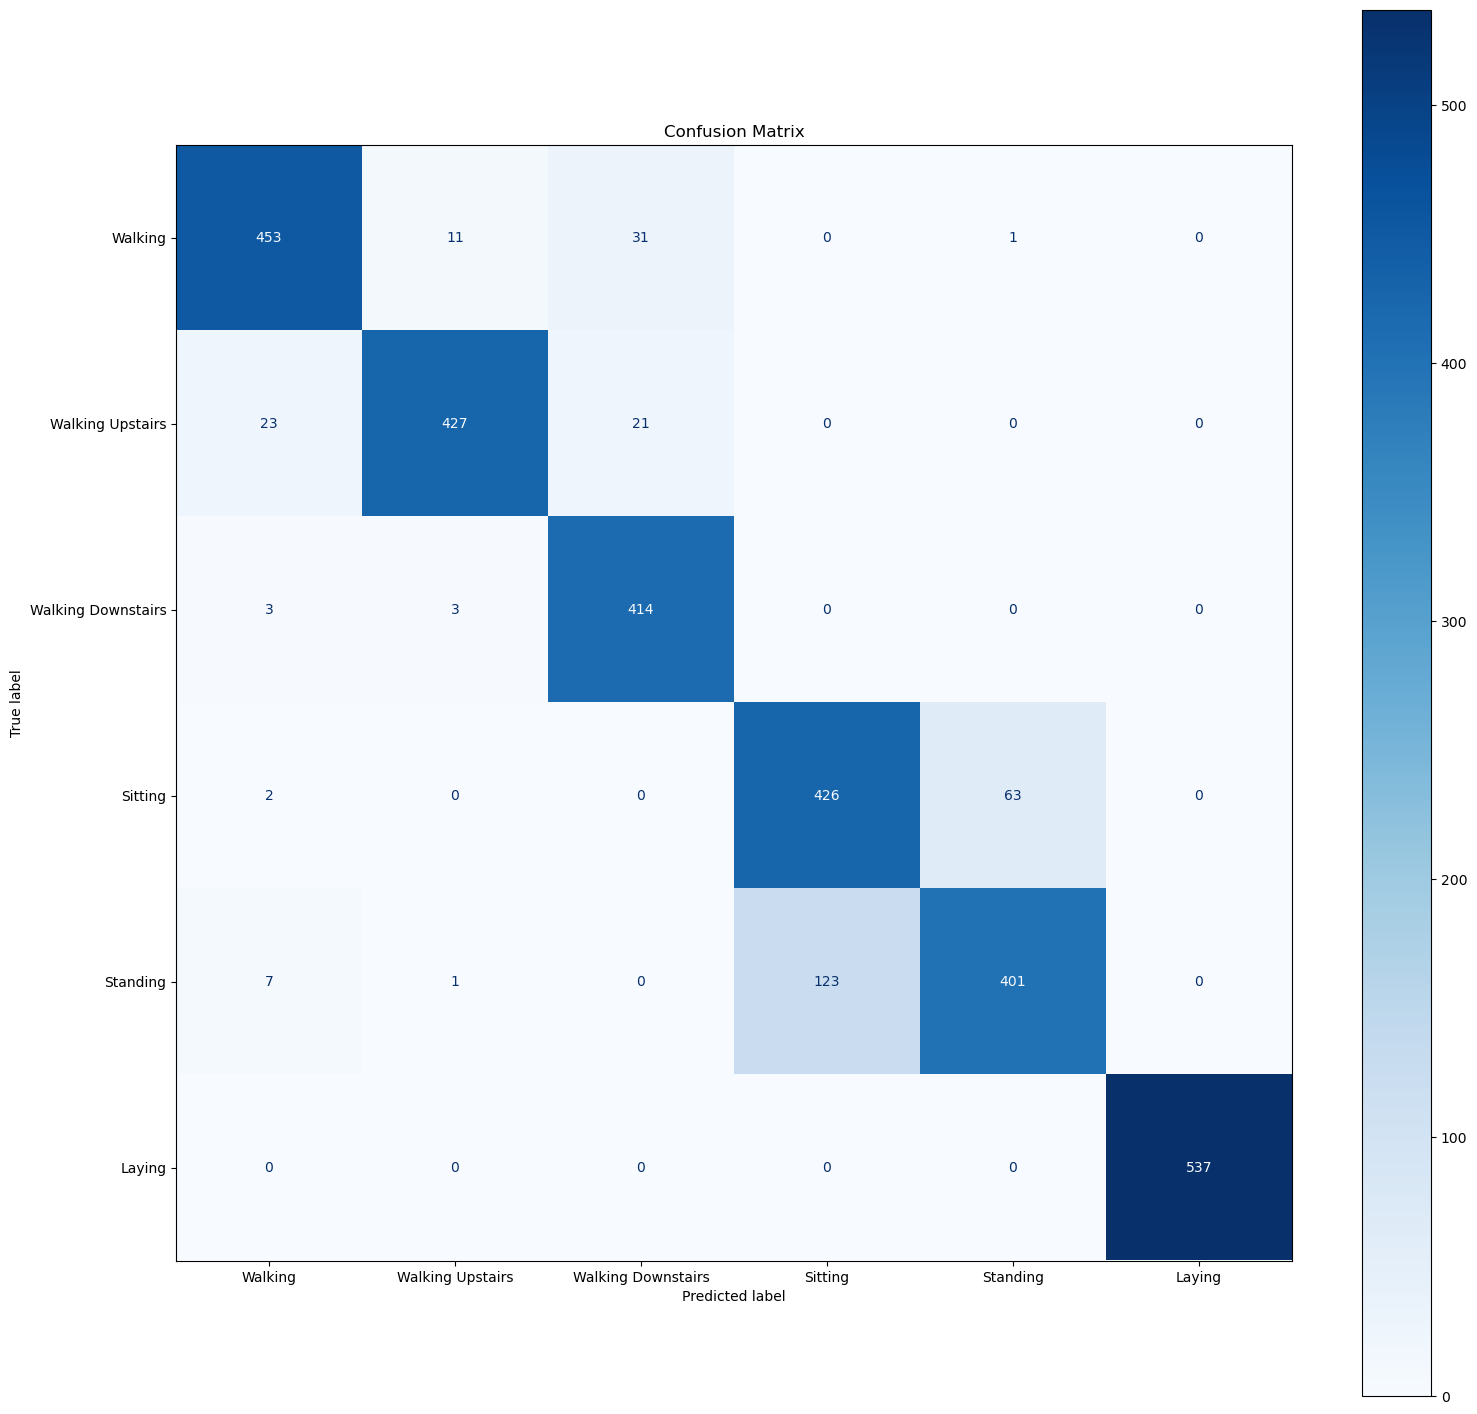

In [23]:
if __name__ == '__main__':
    main(train_input, train_output, test_input, test_output)
